Figure 2 of Wed Poly paper. Show forcing, evolution of polyna with x,y of mld and sea ice extent.

In [2]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage
import seawater as sw


Populating the interactive namespace from numpy and matplotlib


In [3]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print geolon_t.shape

fh=fcor/ht
print fh.shape

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print st_ocean.shape
print potrho.shape
print yt_ocean.shape


(1080, 1440)
(1080, 1440)
(50,)
(80,)
(1080,)


In [4]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)

0.10.0


In [5]:
NP_CntrlDir = '/g/data1/v45/pas561/mom/archive/wombat_jun16z/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
Ocean_File = os.path.join(NP_CntrlDir,'Tdim_output197*/ocean__*.nc')
print Ocean_File
o_np_cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print o_np_cntrl.temp.shape

#this has 3 years of a wind perturbation - get a nice 3 year polynya.
Ocean_File = os.path.join(NP_CntrlDir,'Tdim_output197*/ocean_force*.nc')
print Ocean_File
of_np_cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print of_np_cntrl.tau_x.shape

#this has 3 years of a wind perturbation - get a nice 3 year polynya.
Ocean_File = os.path.join(NP_CntrlDir,'Tdim_output197*/ice__*.nc')
print Ocean_File
i_np_cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print i_np_cntrl.HI.shape


NoNP_CntrlDir = '/g/data1/v45/pas561/mom/archive/wombat_jul15b_r0/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
Ocean_File = os.path.join(NoNP_CntrlDir,'output197*/ocean__*.nc')
print Ocean_File
o_nonp_cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print o_nonp_cntrl.temp.shape

#this has 3 years of a wind perturbation - get a nice 3 year polynya.
Ocean_File = os.path.join(NoNP_CntrlDir,'output197*/ocean_force*.nc')
print Ocean_File
of_nonp_cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print of_nonp_cntrl.tau_x.shape

#this has 3 years of a wind perturbation - get a nice 3 year polynya.
Ocean_File = os.path.join(NoNP_CntrlDir,'output197*/ice__*.nc')
print Ocean_File
i_nonp_cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print i_nonp_cntrl.HI.shape

/g/data1/v45/pas561/mom/archive/wombat_jun16z/Tdim_output197*/ocean__*.nc
(9, 50, 1080, 1440)
/g/data1/v45/pas561/mom/archive/wombat_jun16z/Tdim_output197*/ocean_force*.nc
(108, 1080, 1440)
/g/data1/v45/pas561/mom/archive/wombat_jun16z/Tdim_output197*/ice__*.nc
(108, 1080, 1440)
/g/data1/v45/pas561/mom/archive/wombat_jul15b_r0/output197*/ocean__*.nc
(9, 50, 1080, 1440)
/g/data1/v45/pas561/mom/archive/wombat_jul15b_r0/output197*/ocean_force*.nc
(108, 1080, 1440)
/g/data1/v45/pas561/mom/archive/wombat_jul15b_r0/output197*/ice__*.nc
(108, 1080, 1440)


In [6]:
NP_PertDir = '/g/data1/v45/pas561/mom/archive/wombat_jun16z_wp2_74/'
Ocean_File = os.path.join(NP_PertDir,'output197*/ocean_force*.nc')
print Ocean_File
of_np_pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print of_np_pert.tau_x.shape

/g/data1/v45/pas561/mom/archive/wombat_jun16z_wp2_74/output197*/ocean_force*.nc
(72, 1080, 1440)


In [7]:
#calculate Ekman pumping anomaly
t=36
print of_np_cntrl.tau_x.shape
cntrl_Txf=of_np_cntrl.tau_x[0:t,:,:].mean('time').load()/fcor
cntrl_Tyf=of_np_cntrl.tau_y[0:t,:,:].mean('time').load()/fcor
print cntrl_Txf.shape

cntrl_dTyfdx=np.gradient(cntrl_Tyf,dxt,axis=1)
print cntrl_dTyfdx.shape
cntrl_dTxfdy=np.gradient(cntrl_Txf,dyt,axis=0)
print cntrl_dTxfdy.shape

rho0=1035.0
cntrl_we=(cntrl_dTyfdx-cntrl_dTxfdy)/rho0


print of_np_pert.tau_x.shape
pert_Txf=of_np_pert.tau_x[0:t,:,:].mean('Time').load()/fcor
pert_Tyf=of_np_pert.tau_y[0:t,:,:].mean('Time').load()/fcor
print pert_Tyf.shape

pert_dTyfdx=np.gradient(pert_Tyf,dxt,axis=1)
print pert_dTyfdx.shape
pert_dTxfdy=np.gradient(pert_Txf,dyt,axis=0)
print pert_dTxfdy.shape

rho0=1035.0
pert_we=(pert_dTyfdx-pert_dTxfdy)/rho0

(108, 1080, 1440)


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


(1080, 1440)
(1080, 1440)
(1080, 1440)
(72, 1080, 1440)
(1080, 1440)
(1080, 1440)
(1080, 1440)


In [8]:
#nan and unit conversion of Ekman pumping

m=np.nanmax(cntrl_we[0:300,:])
print m
m=np.nanmin(cntrl_we[0:300,:])
print m

m=np.nanmax(pert_we[0:300,:])
print m
m=np.nanmin(pert_we[0:300,:])
print m

#convert from m/s to m/day
s_day=60*60*24
print s_day
cntrl_we=cntrl_we*s_day
pert_we=pert_we*s_day

m=np.nanmax(cntrl_we[0:300,:])
print m
m=np.nanmin(cntrl_we[0:300,:])
print m

m=np.nanmax(pert_we[0:300,:])
print m
m=np.nanmin(pert_we[0:300,:])
print m


5.96176201289e-05
-5.087233745e-05
5.88809996372e-05
-4.96409108701e-05
86400
5.15096237913
-4.39536995568
5.08731836865
-4.28897469917


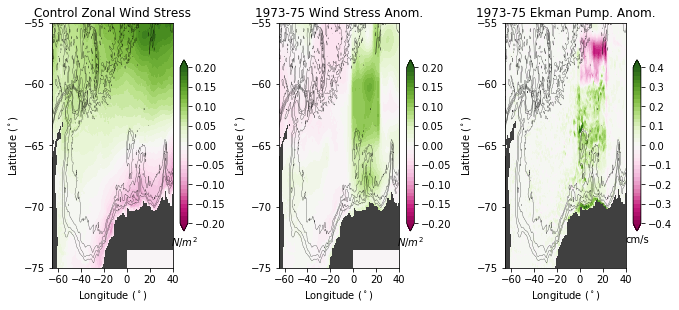

In [20]:
#first 3 panels tx cntrl, 1973-1976 anom, ekman pumping anom
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-.2,.21,.01)
clev3 = np.arange(0,5000,1000)


plt.subplot(331)
plt.gca().patch.set_color('.25')
p1=plt.contourf(xt_ocean,yt_ocean,of_np_cntrl.tau_x[0:12].mean('time').load(),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('$N/m^2$')
clev3 = np.arange(0,5000,1000)
plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylabel('Latitude ($^\circ$)')
plt.ylim((-75,-55))
plt.yticks([-75, -70, -65, -60, -55])
plt.xlabel('Longitude ($^\circ$)')
plt.xlim([-65,40])
plt.xticks([-60, -40, -20, 0, 20, 40])
plt.title('1972 Zonal Wind Stress')

plt.subplot(332)
plt.gca().patch.set_color('.25')
p1=plt.contourf(xt_ocean,yt_ocean,of_np_pert.tau_x[0:36].mean('Time').load()-of_np_cntrl.tau_x[0:3].mean('time').load(),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('$N/m^2$')
clev3 = np.arange(0,5000,1000)
plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylabel('Latitude ($^\circ$)')
plt.ylim((-75,-55))
plt.yticks([-75, -70, -65, -60, -55])
plt.xlabel('Longitude ($^\circ$)')
plt.xlim([-65,40])
plt.xticks([-60, -40, -20, 0, 20, 40])
#plt.title('1973-1975 Zonal Wind Stress Anomaly')
plt.title('1973-75 Wind Stress Anom.')


clev = np.arange(-.4,.402,.02)
plt.subplot(333)
plt.gca().patch.set_color('.25')
p1=plt.contourf(xt_ocean,yt_ocean,pert_we-cntrl_we,cmap=plt.cm.PiYG,levels=clev,extend='both')
#p1=plt.contourf(xt_ocean,yt_ocean,of_np_pert.tau_x[0:3].mean('Time').load()-of_np_cntrl.tau_x[0:3].mean('time').load(),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('cm/s')
clev3 = np.arange(0,5000,1000)
plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylabel('Latitude ($^\circ$)')
plt.ylim((-75,-55))
plt.yticks([-75, -70, -65, -60, -55])
plt.xlabel('Longitude ($^\circ$)')
plt.xlim([-65,40])
plt.xticks([-60, -40, -20, 0, 20, 40])
#plt.title('1973-1975 Zonal Wind Stress Anomaly')
plt.title('1973-75 Ekman Pump. Anom.')


plt.tight_layout()


In [37]:
NP_PertDir = '/g/data1/v45/pas561/mom/archive/wombat_jun16z_wp2_74/'
Ocean_File = os.path.join(NP_PertDir,'output197*/ice__*.nc')
print Ocean_File
i_np_pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print i_np_pert.HI.shape

/g/data1/v45/pas561/mom/archive/wombat_jun16z_wp2_74/output197*/ice__*.nc
(72, 1080, 1440)


[8]
[20]
[32]
[44]
(1080, 1440)


Text(0.5,1,u'b) NP 1974-1976 Sept Sea Ice')

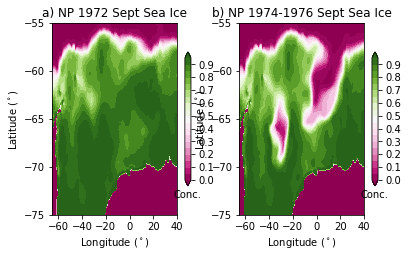

In [41]:
#plot second row, sea ice cntrt & pert, 2 models, with time-series
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

#5:11 of each year gives June-Nov
yr=0
m=np.arange(yr*12+5,yr*12+11)
m=np.arange(yr*12+8,yr*12+9)
print m

clev = np.arange(0,1,.05)

plt.subplot(331)
plt.gca().patch.set_color('.25')
p1=plt.contourf(xt_ocean,yt_ocean,i_np_cntrl.CN[m,:,:,:].sum('ct').mean('time').load(),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Conc.')
#clev3 = np.arange(0,5000,1000)
#plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylabel('Latitude ($^\circ$)')
plt.ylim((-75,-55))
plt.yticks([-75, -70, -65, -60, -55])
plt.xlabel('Longitude ($^\circ$)')
plt.xlim([-65,40])
plt.xticks([-60, -40, -20, 0, 20, 40])
plt.title('a) NP 1972 Sept. Sea Ice')

yr=1
#m=np.arange(yr*12+5,yr*12+11)
m=np.arange(yr*12+8,yr*12+9)
print m
var1=i_np_pert.CN[m,:,:,:].sum('ct').mean('Time').load()
for yr in range(2,4):
    #m=np.arange(yr*12+5,yr*12+11)
    m=np.arange(yr*12+8,yr*12+9)
    print m
    var1=var1+i_np_pert.CN[m,:,:,:].sum('ct').mean('Time').load()

var1=var1/3
print var1.shape

clev = np.arange(0,1,.05)

plt.subplot(332)
plt.gca().patch.set_color('.25')
p1=plt.contourf(xt_ocean,yt_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Conc.')
#clev3 = np.arange(0,5000,1000)
#plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylabel('Latitude ($^\circ$)')
plt.ylim((-75,-55))
plt.yticks([-75, -70, -65, -60, -55])
plt.xlabel('Longitude ($^\circ$)')
plt.xlim([-65,40])
plt.xticks([-60, -40, -20, 0, 20, 40])
plt.title('b) NP 1974-1976 Sept. Sea Ice')



In [16]:
#calc zonal average anomalies
#Plot zonal average anomaly across weddell
x1=np.argwhere(grid_xt<-40)
x2=np.argwhere(grid_xt<15)
x1=x1[-1]
x2=x2[-1]

y1=np.argwhere(grid_yt<-65)
#y2=np.argwhere(xt_ocean<15)
y1=y1[-1]
#y2=y2[-1]
print x1, x2, grid_xt[x1],grid_xt[x2], grid_yt[y1]


[959] [1179] [-40.125] [ 14.875] [-65.02601527]


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


[ 27.5    27.502  27.504  27.506  27.508  27.51   27.512  27.514  27.516
  27.518  27.52   27.522  27.524  27.526  27.528  27.53   27.532  27.534
  27.536  27.538  27.54   27.542  27.544  27.546  27.548  27.55   27.552
  27.554  27.556  27.558  27.56   27.562  27.564  27.566  27.568  27.57
  27.572  27.574  27.576  27.578  27.58   27.582  27.584  27.586  27.588
  27.59   27.592  27.594  27.596  27.598  27.6    27.602  27.604  27.606
  27.608  27.61   27.612  27.614  27.616  27.618  27.62   27.622  27.624
  27.626  27.628  27.63   27.632  27.634  27.636  27.638  27.64   27.642
  27.644  27.646  27.648  27.65   27.652  27.654  27.656  27.658  27.66
  27.662  27.664  27.666  27.668  27.67   27.672  27.674  27.676  27.678
  27.68   27.682  27.684  27.686  27.688  27.69   27.692  27.694  27.696
  27.698  27.7    27.702  27.704  27.706  27.708  27.71   27.712  27.714
  27.716  27.718  27.72   27.722  27.724  27.726  27.728  27.73   27.732
  27.734  27.736  27.738  27.74   27.742  27.744  27.

Text(0.5,0,u'$kg/m^3$')

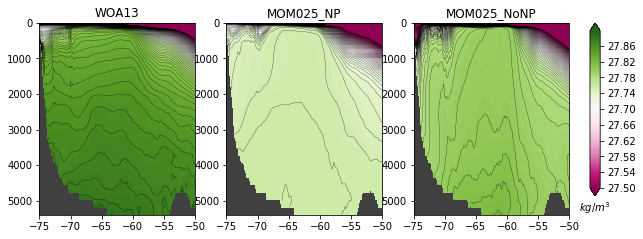

In [22]:
#plot control zavg temp, rho, salt 
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.title('Zonal Avg Tracers 40W-15E')

var1=np.nanmean(woa_rho[:,0:500,x1:x2],axis=2)

clev = np.arange(27.5,27.9,.002)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(27.5,27.9,.005)
print clev3

plt.subplot(3,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('a) WOA13')

yr=0

var1=np_cntrl.pot_rho_0[0:9,:,0:500,x1:x2].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('b) MOM025_NP')

var1=nonp_cntrl.pot_rho_0[0:9,:,0:500,x1:x2].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('c) MOM025_NoNP')

ax3 = plt.axes([0.93,0.68,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$kg/m^3$')




[ -2.00000000e+00  -1.95000000e+00  -1.90000000e+00  -1.85000000e+00
  -1.80000000e+00  -1.75000000e+00  -1.70000000e+00  -1.65000000e+00
  -1.60000000e+00  -1.55000000e+00  -1.50000000e+00  -1.45000000e+00
  -1.40000000e+00  -1.35000000e+00  -1.30000000e+00  -1.25000000e+00
  -1.20000000e+00  -1.15000000e+00  -1.10000000e+00  -1.05000000e+00
  -1.00000000e+00  -9.50000000e-01  -9.00000000e-01  -8.50000000e-01
  -8.00000000e-01  -7.50000000e-01  -7.00000000e-01  -6.50000000e-01
  -6.00000000e-01  -5.50000000e-01  -5.00000000e-01  -4.50000000e-01
  -4.00000000e-01  -3.50000000e-01  -3.00000000e-01  -2.50000000e-01
  -2.00000000e-01  -1.50000000e-01  -1.00000000e-01  -5.00000000e-02
   1.77635684e-15   5.00000000e-02   1.00000000e-01   1.50000000e-01
   2.00000000e-01   2.50000000e-01   3.00000000e-01   3.50000000e-01
   4.00000000e-01   4.50000000e-01   5.00000000e-01   5.50000000e-01
   6.00000000e-01   6.50000000e-01   7.00000000e-01   7.50000000e-01
   8.00000000e-01   8.50000000e-01

/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


(50, 500)
(50, 500)


Text(0.5,0,u'$\\circ C$')

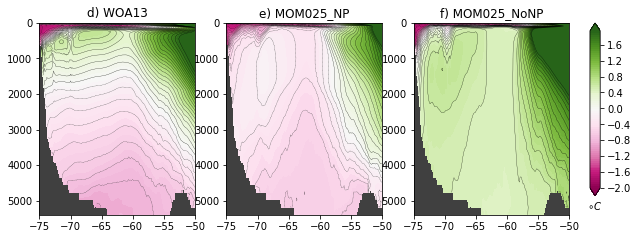

In [24]:
clev = np.arange(-2,2,.05)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(-2,2,.1)
print clev3

var1=np.nanmean(woa_temp[:,0:500,x1:x2],axis=2)

plt.subplot(3,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('d) WOA13')

yr=0

var1=np_cntrl.temp[0:9,:,0:500,x1:x2].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('e) MOM025_NP')

var1=nonp_cntrl.temp[0:9,:,0:500,x1:x2].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('f) MOM025_NoNP')

ax3 = plt.axes([0.93,0.68,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$^\circ C$')



[ 34.    34.01  34.02  34.03  34.04  34.05  34.06  34.07  34.08  34.09
  34.1   34.11  34.12  34.13  34.14  34.15  34.16  34.17  34.18  34.19
  34.2   34.21  34.22  34.23  34.24  34.25  34.26  34.27  34.28  34.29
  34.3   34.31  34.32  34.33  34.34  34.35  34.36  34.37  34.38  34.39
  34.4   34.41  34.42  34.43  34.44  34.45  34.46  34.47  34.48  34.49
  34.5   34.51  34.52  34.53  34.54  34.55  34.56  34.57  34.58  34.59
  34.6   34.61  34.62  34.63  34.64  34.65  34.66  34.67  34.68  34.69
  34.7   34.71  34.72  34.73  34.74  34.75  34.76  34.77  34.78  34.79]
[ 34.    34.02  34.04  34.06  34.08  34.1   34.12  34.14  34.16  34.18
  34.2   34.22  34.24  34.26  34.28  34.3   34.32  34.34  34.36  34.38
  34.4   34.42  34.44  34.46  34.48  34.5   34.52  34.54  34.56  34.58
  34.6   34.62  34.64  34.66  34.68  34.7   34.72  34.74  34.76  34.78]


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


(50, 500)
(50, 500)


Text(0.5,0,u'$S_A$')

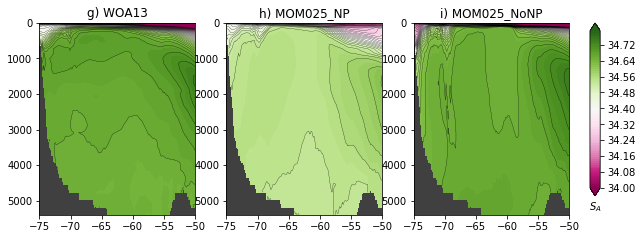

In [49]:
clev = np.arange(34,34.8,.01)
print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(34,34.8,.02)
print clev3

var1=np.nanmean(woa_salt[:,0:500,x1:x2],axis=2)

plt.subplot(3,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('g) WOA13')

yr=0

var1=np_cntrl.salt[0:9,:,0:500,x1:x2].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('h) MOM025_NP')

var1=nonp_cntrl.salt[0:9,:,0:500,x1:x2].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('i) MOM025_NoNP')

ax3 = plt.axes([0.93,0.68,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$S_A$')




/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


(50, 500)
(50, 500)


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:78: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


(50, 500)
(50, 500)


/g/data3/hh5/public/apps/miniconda3/envs/analysis27/lib/python2.7/site-packages/ipykernel/__main__.py:145: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


(50, 500)
(50, 500)


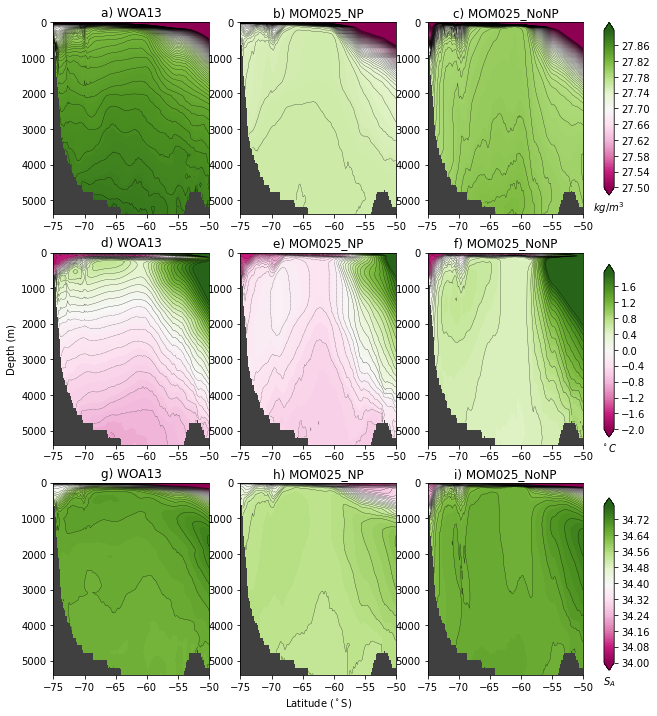

In [54]:
#plot control zavg temp, rho, salt 
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.title('Zonal Avg Tracers 40W-15E')
var1=np.nanmean(woa_rho[:,0:500,x1:x2],axis=2)

clev = np.arange(27.5,27.9,.002)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(27.5,27.9,.005)
#print clev3

plt.subplot(3,3,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('a) WOA13')

yr=0

var1=np_cntrl.pot_rho_0[0:9,:,0:500,x1:x2].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('b) MOM025_NP')

var1=nonp_cntrl.pot_rho_0[0:9,:,0:500,x1:x2].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,3)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1-1000,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1-1000,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('c) MOM025_NoNP')

ax3 = plt.axes([0.93,0.68,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$kg/m^3$')


clev = np.arange(-2,2,.05)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(-2,2,.1)
#print clev3

var1=np.nanmean(woa_temp[:,0:500,x1:x2],axis=2)

plt.subplot(3,3,4)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('d) WOA13')

yr=0

var1=np_cntrl.temp[0:9,:,0:500,x1:x2].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,5)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('e) MOM025_NP')

var1=nonp_cntrl.temp[0:9,:,0:500,x1:x2].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,6)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('f) MOM025_NoNP')

ax3 = plt.axes([0.93,0.40,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$^\circ C$')


clev = np.arange(34,34.8,.01)
#print clev
#clev3 = np.arange(27.66,27.9,.002)
clev3=np.arange(34,34.8,.02)
#print clev3

var1=np.nanmean(woa_salt[:,0:500,x1:x2],axis=2)

plt.subplot(3,3,7)
plt.gca().patch.set_color('.25')
p1=plt.contourf(grid_yt[0:500],zt,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('g) WOA13')

yr=0

var1=np_cntrl.salt[0:9,:,0:500,x1:x2].mean('time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,8)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('h) MOM025_NP')

var1=nonp_cntrl.salt[0:9,:,0:500,x1:x2].mean('Time').mean('xt_ocean').load()
print var1.shape

plt.subplot(3,3,9)
plt.gca().patch.set_color('.25')
p1=plt.contourf(yt_ocean[0:500],st_ocean,var1,cmap=plt.cm.PiYG,levels=clev,extend='both')
plt.contour(yt_ocean[0:500],st_ocean,var1,levels=clev3,colors='k',linewidths=0.25)
#cb=plt.colorbar(orientation='vertical',shrink = 0.7)
#cb.ax.set_xlabel('kg/m3')
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=clev,colors='k',linewidths=0.25)
#plt.contour(yt_ocean[0:500],st_ocean,pert_ztemp-cntrl_ztemp,levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
#plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1034))
#plt.ylabel('Depth (m)')
#plt.xlabel('Latitude ($^\circ$S)')
plt.xlim([-75,-50])
plt.title('i) MOM025_NoNP')

ax3 = plt.axes([0.93,0.13,0.015,0.2])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('$S_A$')

#plt.suptitle('Depth (m)',x=0.4,y=0.1,rotation=90,fontsize=14)
#plt.suptitle('Latitude ($^\circ$)',x=0.5,y=0.2,fontsize=14)

of = '/g/data1a/v45/pas561/mom/archive/wp2_figs/TS_WOCE.png'
plt.savefig(of,dpi=220)

